In [4]:
import numpy as np
import pandas as pd

from scipy.stats import entropy
from copy import deepcopy as copy

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, as_float_array

import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
synth = np.hstack([
    np.linspace(start=-1, stop=5, num=100),
    np.ones(100) * 5,
    5 + 3 * np.linspace(start=0, stop=5, num=100)
])

synth = pd.Series(synth).rolling(50).mean().dropna().values

In [12]:
class MaxentropyDichtomizationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_splits, verbose=False):
        self.n_splits = n_splits
        
        self.n_samples = None
        self.n_features = None
        self._splits = None
        self._splits_indices = None
    
    def _check_X(self, X, n_features=None):
        _X = None
        if not hasattr(X, 'dtype'):
            _X = check_array(as_float_array(X))
        _X = check_array(X)
        
        if self.n_features:
            if _X.shape[1] != self.n_features:
                raise Exception('X has {} columns while {} are expected'.format(_X.shape[1], self.n_features))
        return _X
    
    def _get_maxentropy_split(self, X):
        block_size = X.size
        ix_max_entropy = -1
        max_entropy = -1
        max_probas = None
        for i in range(1, block_size - 1):
            a = np.sum(X < X[i])
            b = np.sum(X >= X[i])

            p = np.array([a / block_size, b / block_size])
            e = -np.sum(np.log(p + 1) * p)

            if max_entropy < e:
                max_probas = p
                max_entropy = e
                ix_max_entropy = i

        if 0 in max_probas:
            return 0, -1

        return max_entropy, ix_max_entropy

    def _dichtomize(self, X):
        _iters = np.log2(self.n_splits)
        if _iters - int(_iters) != 0:
            raise Exception('number of bins should be of a power of 2')

        # make first maxentropy split
        _, initial_bin = self._get_maxentropy_split(X)
        splits_current_feature = [(0, initial_bin), (initial_bin, self.n_samples - 1)]
        for i in range(int(_iters) - 1):
            # an empty list for splits in current iteration
            _splits = list()
            for j in splits_current_feature:
                entropy, index = self._get_maxentropy_split(X[j[0]: j[1]])
                if entropy == 0:
                    _splits += [(j[0], j[1])]
                else:
                    _splits += [(j[0], j[0] + index), (j[0] + index, j[1])]

            splits_current_feature = _splits
            
        return splits_current_feature
    
    def _convert(self, X, ix):
        result = list()
        for x in X.flatten():
            result.append(np.argwhere([k[0] <= x and x < k[1] for k in self._splits[ix]]))
        return np.array(result).flatten()
        
        
    
    def fit(self, X):
        X = self._check_X(X)
        self.n_samples, self.n_features = X.shape
        
        self._splits = list()
        self._splits_indices = list()
        
        for ix in range(self.n_features):
            _indices = self._dichtomize(X[:, ix].flatten())
            
            self._splits_indices.append(_indices)
            self._splits.append([[X[i[0]][0], X[i[1]][0]] for i in _indices])
            
            self._splits[-1][0][0] = -np.inf
            self._splits[-1][-1][1] = np.inf
            
            self._splits = np.array(self._splits)
            
        return self
    
    def transform(self, X):
        _, n_features = X.shape
        X = self._check_X(X, n_features)
        
        X_categorical = list()
        for ix in range(n_features):
            X_categorical.append(self._convert(X, ix).reshape(-1, 1))
            
        return np.vstack(X_categorical)

In [13]:
dicht = MaxentropyDichtomizationTransformer(32)

In [14]:
processed = dicht.fit(synth.reshape(-1, 1)).transform(synth.reshape(-1, 1)).flatten()

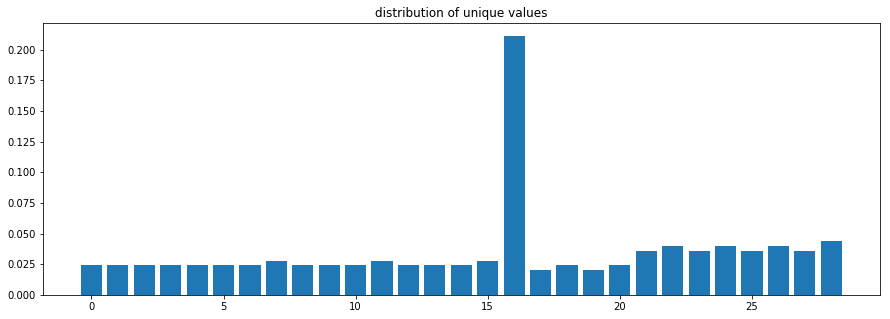

In [23]:
#synth.reshape(-1, 1)
values, counts = np.unique(processed, return_counts=True)
p = counts / np.sum(counts)
-np.sum(np.log(p) * p)

plt.figure(figsize=(15, 5))
plt.bar(np.arange(p.size), p)
plt.title('distribution of unique values')
plt.show()

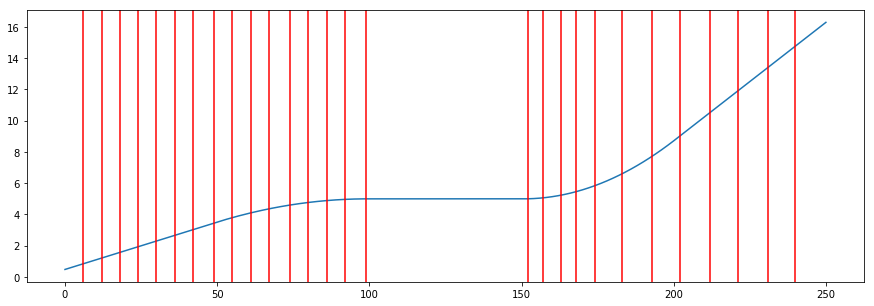

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(synth)
for i in dicht._splits_indices[0][:-1]:
    plt.axvline(x=i[1], color='r')